# Building a Model for Snow Melt: Version 0

The objective is to build the simplest model possible of snow melt, assuming that the snow pile is not insulated and experiences only solar radiation provided by Wunderground data.

## Deliverables:

<ol>
    <li> Derive the equation for your model in its exact mathematical form and in its discretized form. </li>
    <li> Write a python function that predicts the volume loss for a given time series (i.e. period of time) as a function of time.</li>
    <li> Compare volume loss between 2017-06-11 and 2017-10-01 and between 2018-06-11 and 2018-10-01</li>
    </ol>
    
## Help

Consider the ODE:

$$
\frac{df}{dt}=g(t)
$$

The solution of the continuous problem between time $0$ and $t$ is

$$
\int_{0}^t\frac{df}{dt}dt=f(t)-f(0)=\int_{0}^tg(t)dt\Leftrightarrow f(t)=f(0)+\int_{0}^tg(t)dt
$$

The discretization of this ODE at a first order accuracy in time writes:

$$
\frac{f(t+\Delta t)-f(t)}{\Delta t}=g(t)
$$

Therefore

$$
f(t+\Delta t)=f(t)+(\Delta t)g(t)
$$

or

$$
f(t_n) = f(0) +\sum_{k=0}^{n-1}\Delta t\,g(t_k),\; n\leq1\text{ and } t_n=n\Delta t
$$


## 1 Equations

The simplified system assumes:
<ol>
    <li>The only mode of heat transfer radiation onto the pile is solar radiation.</li>
    <li>The worst case scenario is assumed, the incidence of radiation is assumed to be perpendicular to the exposed surface area $A_{sr}$.</li>
    <li>The density of snow is in the range $500-600kg/m^3$</li>
    <li>The effect of the melt water film is ignored</li>
    </ol>
Under these assumptioms, the conservation of energy applied to the snow pile writes:

$$
\rho_{snow}h_{L,snow}A_{sr}\frac{dh}{dt}=-q''_{sr}A_{sr}
$$
where $h$ is the height of the snow pile. Since $A_{sr}dh/dt=dV_{loss}/dt$,

$$
\frac{dV_{loss}}{dt}=-\frac{q''_{sr}A_{sr}}{\rho_{snow}h_{L,snow}}
$$
since 

### Python set-up and useful functions

In [11]:
%matplotlib inline 


import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc
import h5py


import sympy as sym




font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }


from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)


In [12]:
import pandas as pd
from pandas import Series

import os
print(os.path.abspath)
weather1 = pd.read_csv("../Excel/Weather_KVTCRAFT2_2017-06-11_2018-03-20.csv", delimiter=",",header=0,date_parser=[1])
weather2 = pd.read_csv("../Excel/Weather_KVTCRAFT2_2018-03-23_2018-10-16.csv", delimiter=",",header=0,date_parser=[1])
weather = [weather1, weather2]
weather = pd.concat(weather)
weather['time'] = pd.to_timedelta(weather['time'].astype(str))
weather['date'] = pd.to_datetime(weather['date'])
weather['date'] = weather['date'] + weather['time']
weather['date'] = pd.to_datetime(weather['date'])

# interpolation to 30 mins intervals done for you. You are welcome. You should still try to understand how it works.
weather = weather.set_index('date')
weather30mins_tmp = weather.resample('30Min').mean()
weather30mins = weather30mins_tmp.interpolate(method='linear')
# weather.set_index('date')
weather30mins.head(10)

<function abspath at 0x107a72e18>


,temperature,dewpoint,humidity,wind_speed,wind_gust_speed,wind_dir_degrees,pressure,windchill,heatindex,precip,precip_rate,precip_1hr,precip_today,solarradiation,uv_index,temperature_indoor,software_type,event,conditions
date,,,,,,,,,,,,,,,,,,,
2017-06-11 00:00:00,17.1,14.4,83.0,0.0,0.0,360.0,1010.7,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-06-11 00:30:00,17.3,14.4,83.0,0.0,3.2,360.0,1010.7,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-06-11 01:00:00,17.2,13.9,82.0,0.0,0.0,360.0,1011.1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-06-11 01:30:00,16.4,13.9,85.0,0.0,0.0,360.0,1010.7,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-06-11 02:00:00,16.4,13.9,86.0,0.0,1.6,360.0,1010.7,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-06-11 02:30:00,16.4,13.9,86.0,0.0,0.0,360.0,1010.7,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-06-11 03:00:00,16.4,13.9,85.0,0.0,0.0,360.0,1010.7,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-06-11 03:30:00,16.6,13.9,85.0,0.0,0.0,360.0,1010.7,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-06-11 04:00:00,16.3,13.9,86.0,0.0,0.0,360.0,1010.7,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


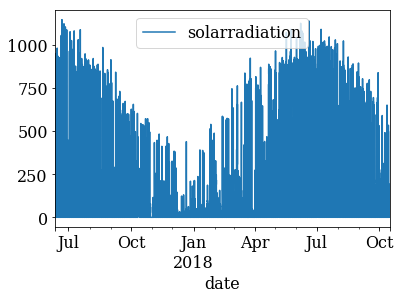

In [13]:
ax = weather30mins.plot( y = 'solarradiation')

In [14]:
weather30mins.columns

Index(['temperature', 'dewpoint', 'humidity', 'wind_speed', 'wind_gust_speed',
       'wind_dir_degrees', 'pressure', 'windchill', 'heatindex', 'precip',
       'precip_rate', 'precip_1hr', 'precip_today', 'solarradiation',
       'uv_index', 'temperature_indoor', 'software_type', 'event',
       'conditions'],
      dtype='object')

In [15]:
sub_weather17 = weather30mins['2017-06-11':'2017-10-01']
solarradiation17 = np.array(sub_weather17['solarradiation'])
sub_weather18 = weather30mins['2018-06-11':'2018-10-01']
solarradiation18 = np.array(sub_weather18['solarradiation'])

In [16]:
dt = 1800.
rho = 600.
h_L= 334000
A = 500
def melt(q):
    """q must be solar radiation heat rate (W), i.e. solar radiation heat flux 
    times exposed surface area""" 
    global dt, rho, h_L
    V_dt = -dt*q/(rho*h_L)
    V = np.cumsum(V_dt)
    return V

Vloss17 = melt(solarradiation17*A)
Vloss18 = melt(solarradiation18*A)


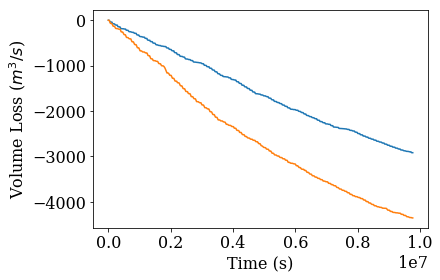

In [17]:
time17 = np.arange(start = 0,stop=(len(solarradiation17)*1800),step=1800)
time18 = np.arange(start = 0,stop=(len(solarradiation18)*1800),step=1800)
plt.plot(time17,Vloss17)
plt.plot(time18,Vloss18)
plt.xlabel("Time (s)",fontdict = font)
plt.ylabel("Volume Loss ($m^3/s$)",fontdict = font)
plt.show()

In [18]:
from scipy.constants import convert_temperature
def C2K(T):
    return convert_temperature(T,'Celsius','Kelvin')
def C2F(T):
    return convert_temperature(T,'Celsius','Fahrenheit')
def F2K(T):
    return convert_temperature(T,'Fahrenheit','Kelvin')
def F2C(T):
    return convert_temperature(T,'Fahrenheit','Celsius')
def K2F(T):
    return convert_temperature(T,'Kelvin','Fahrenheit')
def K2C(T):
    return convert_temperature(T,'Kelvin','Celsius')
from scipy.optimize import fsolve
T_melt = 0. #C
g_reflective = 0.1
sub_weather = weather30mins['2018-04-01':'2018-10-01']
A_top = 2800
A_soil = 400
q_solar = np.array(sub_weather['solarradiation'])*A_top # W
T_atm = np.array(sub_weather['temperature'])
k_mulch = 0.07 #W/m.K
d_mulch = 0.2 #m
DeltaT_soil = 8 #K
k_soil = 1 #W/m.K
d_soil = 1 #m
q_soil = k_soil*A_soil*DeltaT_soil/d_soil
dt = 1800.
rho_snow = 600.
h_L_snow= 334000
epsilon_top = 0.8
from scipy.constants import sigma
def melt_v1(q_solar,T_sky,q_soil):
    """q must be solar radiation heat rate (W), i.e. solar radiation heat flux 
    times exposed surface area""" 
    global dt, rho, h_L
    N = len(q_solar)
    T_s = np.zeros(N)
    for i in range(N):
        T_sky_i = T_sky[i]
        def surfconsener(T_s):
            return -k_mulch*A_top/d_mulch*(T_s-T_melt) \
        +g_reflective*q_solar[i] \
        +epsilon_top*sigma*A_top*(C2K(T_sky[i])**4-C2K(T_s)**4)
        T_s[i] = fsolve(surfconsener,T_sky[i]/2)
    q_top = k_mulch*A_top/d_mulch*(T_s-T_melt)
    q = q_top+q_soil
    V_dt = -dt*q/(rho*h_L)
    V = np.cumsum(V_dt)
    return V,T_s

In [19]:
Vloss,T_s = melt_v1(q_solar,T_atm,q_soil)

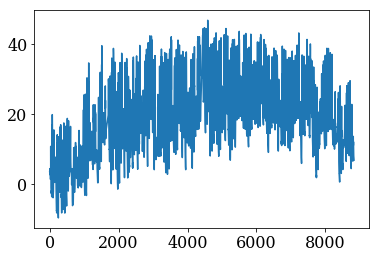

In [20]:
plt.plot(T_s)

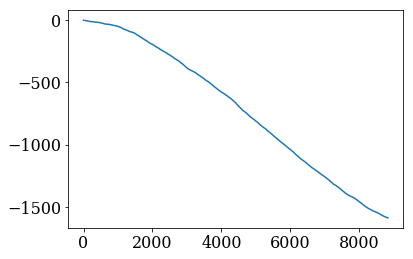

In [21]:
plt.plot(Vloss)
# plt.plot(T_atm)

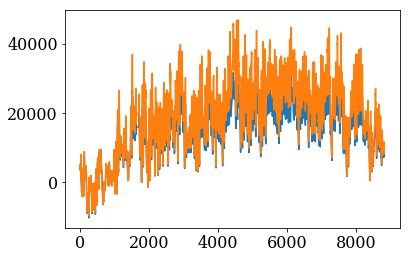

In [22]:
plt.plot(k_mulch*A_top/d_mulch*(T_atm-T_melt))
plt.plot(epsilon_top*sigma*A_top*(C2K(T_atm)**4-C2K(0.9*T_atm)**4))

In [23]:
T_atm

array([3.9, 4. , 4.4, ..., 7.4, 7.4, 7.4])

In [24]:
def pile_volume(R,h,L):
    volume = np.pi*(R**2*L+(1/6)*h*(3*R**2 + h**2))
    area_ground = 2*np.pi*R*L
    area_top = np.pi*(R**2+h**2)
    return volume,area_ground,area_top

In [128]:
pile_volume(30,4,2)

(11343.243874561545, 376.99111843077515, 2877.6988706882503)